# Who cares?  Drivers of engagement in International Development

With over a quarter of the world's population on Facebook, it is the key platform that should be part of any organizations outreach strategy.  How do international development organizations differ in their approach to community engagement? 
Do the timing of posts and frequency of posts matter?  Does using videos and photos provide attention getting value?  What topics of coverage generates greater comments? Are users sensitive to subjectivity or degree of negative versus positive wording in the content?

## Data

This project uses the public page data of key organizations in international development and their feeds over time that is available from Facebook's graph API to figure out key approaches in prodcuing social media and increasing engagement in these organizations.  

## Key limitations

The analysis is limited by the scope of what is available on the public data sets.  In particular, there is little available information on the demographics of followers of the pages.  The modeling also By leveraging demographic data of followers it can help to move toward personalization, but also providing an indicator of sophistication and quality of its user base.  Long-term automating the personalization of content to appeal to these groups will be key to increasing engagement, but also could have a role in driving accountability in these organizations.


In [15]:
import pandas as pd
import urllib.request as urlrequest
import json
import datetime
import csv
import time
import re
import numpy as np
#Natural language processing packages
import nltk
#nltk.download()
from textblob import TextBlob
import pickle

#this is to get access to twitter feeds
import tweepy

In [4]:
#Function accesses bare minimum data in Graph explorer
def getFacebookPageData(page_id, access_token):
    
    # construct the URL string
    base = "https://graph.facebook.com/v2.9"
    node = "/" + page_id
    parameters = "/?fields=about,engagement,fan_count,affiliation,company_overview,country_page_likes,talking_about_count,overall_star_rating,rating_count&access_token=%s" % access_token
    url = base + node + parameters
    
    #can use this to retrieve metadata information that is available
    #node = "/" + pageid + "/?metadata=1"
    
    # retrieve data
    req = urlrequest.Request(url)
    response = urlrequest.urlopen(req)
    data = json.loads(response.read())
    
    fan_count = data["fan_count"]
    talking_about_count = data["talking_about_count"]
    star_rating = '' if 'overall_star_rating' not in data.keys() else data["overall_star_rating"]
    
    return(fan_count,talking_about_count,star_rating)

In [5]:
app_id = '2026494927581067' # found at developer.facebook.com
app_secret = '8ca55671c30d485e2c882361e61a8405' # found at developer.facebook.com
access_token = app_id + "|" + app_secret

In [6]:
punctuation = ["'",'''"''',".",";","(",")",",",":","&","*","\\n","!",">","#","$","_"]
other_clean = ["b'","target=_blank>","</a>","fgm/e","*","-","/"]
uselesswords = ["about","after","based","before","being","between",
                "could","create","didnt"
                "files","first","following","function",
                "given","including",
                "looking","other","people","possible","question","remember"
                "series","service","several","short","should",
                "their","there","these","think","through","tried","trying",
                "using","where","which","without","while","would","years","seems"]

def repl(m):
    #print(m.group(1) + m.group(2))
    return(m.group(1) + m.group(2))

def clean_string(string):
    textstr = str.lower(str(string))
    textstr, nums = re.subn(r'http(.*?)(\s|$)',' ',textstr)
    #print("Number of http subs", nums)
    textstr, nums = re.subn(r'\\x\w\w',' ',textstr)
    #print("Number of \\xe2\\x80 subs", nums)
    #textstr, nums = re.subn(r'\\xc3\\\w{3}',' ',textstr)
    #print("Number of \xc3 subs", nums)
    textstr, nums = re.subn(r'\?','',textstr)
    #print("Number of ? removed", nums)
    #remove space from words that should be treated as one
    textstr, nums = re.subn(r'(human|united)\s(rights|nations)',repl,textstr)
    textstr = textstr.replace("human rights","humanrights")
    textstr = textstr.replace("united nations","unitednations")
    textstr = textstr.replace("un ","unitednations")
    #print("Number of concatenated", nums)
    for i in other_clean:
        textstr = textstr.replace(i," ")
    for i in punctuation:
        textstr = textstr.replace(i,"")
    for w in uselesswords:
        textstr = textstr.replace(w,"")
    return(textstr)

In [7]:
#Function for parsing message data
def split_strings(string):
    split_string = string.split(" ")
    split_string = [word for word in split_string if len(word) >= 5 or word in ["un","girl","boy","boys","imf"]]
    for w in uselesswords:
        try:
            split_string.remove(w)
        except ValueError:
            pass
    return split_string

In [8]:
#print(undata.head())
#Natural language processing can apply weights to each string with important words and see what gets most attention
def wordrank(data):
    term_weight = {}
    term_count = {}
    split_message = [split_strings(m) for m in data["clean_message"]]
    for i in range(0,len(data)):
        #print(split_message[i])
        for w in split_message[i]:
            if w in term_weight:
                term_weight[w] += data["num_likes"].iloc[i]
            else:
                term_weight[w] = data["num_likes"].iloc[i]
            if w in term_count:
                term_count[w] += 1
            else:
                term_count[w] = 1
    term_impact = {}
    for key, val in term_weight.items():
        term_impact[key] = round(term_weight[key]/term_count[key],1)
        #print(key, term_weight[key],term_count[key],term_impact[key])
    #should likewise weigh uniqueness
    return term_impact

In [304]:
import sys
from collections import Counter
import operator
import functools

subjects = {'aid_effectiveness' : ['aid effectiveness'],
            'climate_change' : ['climate change'],
            'corruption_governance' : ['corruption','corruption and transparency','governance'],
            'data_technology' : ['data and technology'],
            'education' : ['education'],
            'finance_investment' : ['finance','investment'],
            'gender' : ['gender'],
            'global_health' : ['global health'],
            'infrastructure' : ['infrastructure'],
            #'interntl_inst' : ['international institutions'],
            'migration' : ['human migration'],
            'povertyineqgrowth' : ['poverty','inequality and growth'],
            'intltrade' : ['international trade']
}


# Using simple categorization using the top 20 individual words and top 10 (bigram words) of each subject to cateogrize/tag
most_freq_nouns = {}
most_freq_bigrams = {}
for key,val in subjects.items():
    fname = 'C:\\JobApplications\\Facebook\\TrainSubjects\\'+key+'.csv'
    with open(fname, 'rb') as f:
        most_freq_nouns[key] = pickle.load(f)
    fname = 'C:\\JobApplications\\Facebook\\TrainSubjects\\'+key+'_bigrams.csv'
    with open(fname, 'rb') as f:
        most_freq_bigrams[key] = pickle.load(f)    

def tag_subject(text_counts, text_counts_bigrams):
    score_subject = {}
    for key, val in subjects.items():
        score_subject[key] = 0
        for word, wrdcnt in text_counts.items():
            if word in most_freq_nouns[key]:
                score_subject[key] += wrdcnt
        for word, wrdcnt in text_counts_bigrams.items():
            if word in most_freq_bigrams[key]:
                score_subject[key] += wrdcnt
    max_value = max(score_subject.values())
    if max_value > 0:
        max_keys = [k for k, v in score_subject.items() if v == max_value] # getting all keys containing the `maximum`
        #print(max_keys[0])
        return(max_keys[0])
    else:
        return('other')

#This will call all of the critical data given a pageid

def analyze_page(pageid,details=0):

    fan_count,talking_about_count,star_rating = getFacebookPageData(pageid, access_token)
    print("Fan page count: {}".format(fan_count))
    print("Talking about count: {}".format(talking_about_count))

    data = pd.read_csv(pageid + '_facebook_statuses.csv',encoding="utf-8",parse_dates=["status_published"])
    print("Dataset shape: {}".format(data.shape))
    data["publish_year"] = [row.year for row in data["status_published"]]
    data["publish_hour"] = [row.hour for row in data["status_published"]]
    #there are some with data that are way too early in terms of publication (so something is wrong with the data)
    data = data.loc[data["publish_year"]>=2006]
    
    data["publish_month"] = [row.month for row in data["status_published"]]
    print("Minimum year: {}".format(data["publish_year"].min()))
    data["clean_message"] = [clean_string(str(data['status_message'][i])+" "+str(data['status_description'][i])) for i in range(0,len(data))]  

    #note that we do not have to clean the data as precisely to extract subjects (more important for training data)
    text_counts = [Counter(str(message).split()) for message in data['clean_message']]
    #print(text_counts[0:20])
    #note that we do not have to clean the data as precisely to extract subjects (more important for training data)
    text_counts_bigrams = [Counter(list(nltk.bigrams(str(message).split()))) for message in data['clean_message']]
    data['tag_subject'] = [tag_subject(text_counts[i],text_counts_bigrams[i]) for i in range(0,len(data))]
    data = pd.concat([data, pd.get_dummies(data["tag_subject"])], axis=1)
    
    #Sentiment analysis (polarity ranges between -1/1 indicating positive or negative sentiment)
    #(subjectivity ranges between 0 to 1 indicating objective at 0 and subjective at 1)
    data["message_polarity"] = [TextBlob(str(row)).sentiment.polarity for row in data["status_message"]]
    data["message_subjectivity"] = [TextBlob(str(row)).sentiment.subjectivity for row in data["status_message"]]
    
    #Hours that have lapsed since last post
    data.sort_values("status_published",ascending=True,inplace=True)
    data["last_post"] = data["status_published"]-data["status_published"].shift(1)
    data["last_post"].fillna(0,inplace=True)
    data["last_post_hrs"] = [row.days*24 + row.seconds/3600 for row in data["last_post"]]
    
    #Create day of week where sunday is the firstday
    data["day_of_week"] = [row.weekday() for row in data["status_published"]]
    
    #Generate the number of posts in previous 24 hours
    data["rounded_hour"] = [row.replace(minute=0,second=0) for row in data["status_published"]]
    data["date"] = [datetime.datetime(row.year,row.month,row.day) for row in data["status_published"]]
    
    #Generate message length (approximate...)
    data["len_message"] = [len(split_strings(str(m))) for m in data["status_message"]]

    #Final additional variables used for summary statistics/regression analysis
    data['post'] = 1
    data["photo"] = data["status_type"] == "photo"
    data["video"] = data["status_type"] == "video"
    data["positive"] = data["message_polarity"] >= 0.1
    data["positive_polarity"] = data["positive"]*data["message_polarity"]
    data["neutral"] = np.abs(data["message_polarity"]) <= 0.1
    data["negative"] = data["message_polarity"] <= -0.1
    data["negative_polarity"] = (-1)*data["negative"]*data["message_polarity"]
    
    # Create an empty dataframe
    df = pd.DataFrame()
    # Extract important columns from the datetime variable
    df['datetime'] = data["status_published"]
    df[['num_likes','num_shares','num_comments']] = data[['num_likes','num_shares','num_comments']]
    df["post"] = 1    
    # Convert that column into a datetime datatype
    df['datetime'] = pd.to_datetime(df['datetime'])
    # Set the datetime column as the index
    df.index = df['datetime'] 
    
    #Create a column of num posts per hour
    temp1 = df.resample('H').sum()
    temp1.fillna(0,inplace=True)
    xcol1 = []
    xcol2 = []
    for v in ["post"]:
        temp1["num_"+v+"_L24hrs"] = temp1[v].rolling(window=24).sum().shift(1)
        xcol1.append("num_"+v+"_L24hrs")
    temp1 = temp1[xcol1]
    temp1.reset_index(inplace=True)
    temp1["rounded_hour"] = temp1["datetime"]
    temp2 = df.resample('H').mean()
    for v in ["num_likes","num_shares","num_comments"]:
        temp2["avg_"+v+"_L24hrs"] = temp2[v].rolling(window=24).sum().shift(1)
        xcol2.append("avg_"+v+"_L24hrs")
    temp2 = temp2[xcol2]
    temp2.reset_index(inplace=True)
    temp2["rounded_hour"] = temp2["datetime"]
    #print(temp1.head())
    data = pd.merge(data,temp1,how="left",on="rounded_hour")
    data = pd.merge(data,temp2,how="left",on="rounded_hour")    
    
    #Create a column of num posts per day
    temp1 = df.resample('D').sum()
    temp1.fillna(0,inplace=True)
    for v in ["post"]:
        temp1["num_"+v+"_L7days"] = temp1[v].rolling(window=7).sum().shift(1)
        temp1["num_"+v+"_L30days"] = temp1[v].rolling(window=30).sum().shift(1)
    temp1.reset_index(inplace=True)
    temp1["date"] = temp1["datetime"]
    temp2 = df.resample('D').mean()
    for v in ["num_likes","num_shares","num_comments"]:
        temp2["avg_"+v+"_L7days"] = temp2[v].rolling(window=7).sum().shift(1)   
        temp2["avg_"+v+"_L30days"] = temp2[v].rolling(window=30).sum().shift(1)
    temp2.reset_index(inplace=True)
    temp2["date"] = temp2["datetime"]
    data = pd.merge(data,temp1,how="left",on="date")
    data = pd.merge(data,temp2,how="left",on="date")       
    
    #message data is now pretty clean we should be able to parse the data and store it in different words to start analyzing categories
    #to focus discussion we will first look at categories that are one standard deviations above the mean in (likes, comments, shares)
    descr = data.describe()
    for v in ["num_likes","num_comments","num_shares"]:
        data["plus1sd" + v] = data[v] >= (descr.loc["mean",v]+1*descr.loc["std",v])
        #print(data["plus1sd" + v].value_counts())
        
    one_string = " ".join(data["clean_message"])
    split_train = pd.Series(split_strings(one_string))
    print("Number of likes over time: {}".format(round(data["num_likes"].sum())))
    print("Average likes per post: {}".format(round(data["num_likes"].sum()/len(data),1)))
    counts = split_train.value_counts()

    word_impact = wordrank(data)
    word_sort = sorted(word_impact.items(), key=lambda x:x[1], reverse=True)
    
    if details == 1:
        print("High impact words")
        print(word_sort[0:50])
        
        print(data.describe())
        print(data.corr())
        for row in undata["status_message"]:
            print(clean_string(row))

        data["clean_message"] = [clean_string(row) for row in data["status_message"]]
        print(data.head())
    
    return data

In [431]:
mapdef = { 'AsianDevBank': 'adb',
          'IADB.org': 'iadb',
          'UNDP': 'undp',
          'unitednations': 'un',
          'unitednationshumanrights': 'unhr',
          'USAID': 'usaid',
          'worldbank': 'wb'
}

mapdefdata = create_data(mapdef)

Page: AsianDevBank
Fan page count: 206265
Talking about count: 41213
Dataset shape: (3034, 11)
Minimum year: 2010
Number of likes over time: 3547319
Average likes per post: 1169.6
Page: IADB.org
Fan page count: 63978
Talking about count: 233
Dataset shape: (5137, 11)
Minimum year: 2009
Number of likes over time: 60484
Average likes per post: 11.8
Page: UNDP
Fan page count: 1172802
Talking about count: 3032
Dataset shape: (7093, 11)
Minimum year: 2009
Number of likes over time: 2337697
Average likes per post: 330.0
Page: unitednations
Fan page count: 2337499
Talking about count: 21687
Dataset shape: (7336, 11)
Minimum year: 2006
Number of likes over time: 2977603
Average likes per post: 406.7
Page: unitednationshumanrights
Fan page count: 1777643
Talking about count: 11797
Dataset shape: (4602, 11)
Minimum year: 2008
Number of likes over time: 2324215
Average likes per post: 506.3
Page: USAID
Fan page count: 693951
Talking about count: 1946
Dataset shape: (5535, 11)
Minimum year: 2009
N

In [432]:
import sqlite3

def create_data(mapdef):
    mapdefdata = {}
    for key, val in mapdef.items():
        print("Page: {}".format(key))
        mapdefdata[key] = analyze_page(key)
    return mapdefdata
        
def summarize_data(mapdef):
    
    conn = sqlite3.connect("temp.db")
    cur = conn.cursor()

    for key, val in mapdef.items():
        data = val
        data['dset']=key
        data["time_delta"] = data["status_published"].max() -data["status_published"].min()
        data["days_on_fb"] = [int(row.days) for row in data["time_delta"]]
        xcols = []
        for col in data.columns:
            if col.find('_x') < 0 and col.find('_y') < 0 and col not in ['time_delta','status_published','date','last_post']:
                xcols.append(col)
        #print(xcols)
        #xcols = ["status_published","date","days_on_fb","photo","video","positive","neutral","negative","message_polarity",
        #         "message_subjectivity","num_likes","num_comments","num_shares","post","dset"]
        descr = data[xcols].describe()
        #print(data[xcols].dtypes)
        if key == "AsianDevBank":
            data[xcols].to_sql(name="alldata",con=conn,if_exists='replace')
        else:
            data[xcols].to_sql(name="alldata",con=conn,if_exists='append')
        #print(data.head())
        
    #query = "SELECT (AVG) post, (AVG) video FROM alldata GROUP BY set;"
    query = "PRAGMA table_info(alldata);"
    #print(cur.execute(query).fetchall())
    query = 'SELECT dset, SUM(post), AVG(days_on_fb), SUM(post)/AVG(days_on_fb), AVG(photo),AVG(video), AVG(positive),AVG(neutral), AVG(negative), AVG(message_polarity), AVG(message_subjectivity), AVG(num_likes) as num_likes, AVG(num_comments) as num_comments, AVG(num_shares) as num_shares, AVG(povertyineqgrowth), AVG(aid_effectiveness), AVG(climate_change), AVG(corruption_governance), AVG(education), AVG(gender), AVG(data_technology), AVG(finance_investment), AVG(global_health), AVG(infrastructure), AVG(migration), AVG(intltrade), AVG(other) FROM alldata GROUP BY dset;'
    cur.execute(query)
    results = cur.fetchall()
    #print(results)
    summarydata = pd.read_sql(query,conn)
    cur.close()
    conn.close()
    return(summarydata.round(3))


In [433]:
#print(mapdefdata['worldbank'].columns)
summarydata = summarize_data(mapdefdata)

In [434]:
summarydata.style
#summarydata

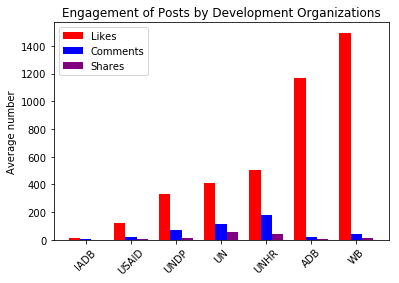

In [435]:
maporgnames = {'AsianDevBank': 'ADB',
              'IADB.org': 'IADB',
              'UNDP':'UNDP',
              'USAID':'USAID',
              'unitednations':'UN',
              'unitednationshumanrights':'UNHR',
              'worldbank':'WB'
             }

summarydata['newnames'] = list(map(maporgnames.get,summarydata['dset']))
summarydata.sort_values('num_likes',inplace=True)
fig, ax = plt.subplots()
ax.set_ylabel('Average number')
ax.set_title('Engagement of Posts by Development Organizations')
ind = np.arange(len(summarydata))  # the x locations for the groups
width = 0.25       # the width of the bars
rects1 = ax.bar(ind, summarydata['num_likes'], width, color='r')
rects2 = ax.bar(ind + width, summarydata['num_shares'], width, color='b')
rects3 = ax.bar(ind + 2*width, summarydata['num_comments'], width, color='purple')
ax.set_xticks(ind + width)
ax.set_xticklabels(summarydata['newnames'],rotation=45)
ax.legend((rects1[0], rects2[0], rects3[0]), ('Likes', 'Comments', 'Shares'), loc=2)

## Posting frequency and content 

1. UNDP has the highest share of postings per day at 2.3 compared to less than 1.6 for most of the other organizations.
2. Half of World Bank and United Nations posts contain photos, while only less than 20 percent of all posts are videos.
3. Messages are mostly positive or neutral with very messages indicated as negative (based on ntlk tagging).  However, united nations human rights postings are the least positive of all the organization pages.
4. Messages are on average not considered to be highly subjective (and closer to objective).
5. Of the development organizations World Bank and the Asian Development Bank get the most number of likes
6. However, UNDP and UN human rights pages get many more comments at over 40 comments per post even though they get half the number of likes.  Possibly indicating there is more direct interest and engagement with the content.  These organizations also have far higher re-shares of their posts at over 100 (see graph above).
7. World Bank's primary focus of posts is on poverty inequality at 30% of all posts.  ADB has the next highest share at 17%.  Posts by the UN are more likely than other organizations to focus on issues of corruption and governance with 15% all posts touching on the subject.


In [404]:
#Relevant plots across

%matplotlib inline
import matplotlib.pyplot as plt


mapcolors = { 'AsianDevBank': 'blue',
          'IADB.org': 'red',
          #'UNDP': 'green',
          'unitednations': 'orange',
          'unitednationshumanrights': 'pink',
          'USAID': 'purple',
          'worldbank': 'green'
}


def graph_data(mapdef):
    pages = ['AsianDevBank','unitednations','worldbank']
    for v in ['post','num_likes','num_shares','num_comments']:
        #initial set-up of the graphs
        fig = plt.figure(figsize=(5, 5))
        ax = fig.add_subplot(1,1,1)
        ax.set_xlabel("Date")
        for key, val in mapdef.items():
            if key in pages:
                temp = val[[v,"status_published","publish_year"]]
                temp["date"] = [datetime.datetime(row.year,row.month,1) for row in temp["status_published"]]
                if v in ['post']:
                    average_month = temp.groupby("date").sum()
                    maintitle = "Number " + v + " Per Month"
                else:
                    average_month = temp.groupby("date").mean()
                    maintitle = "Average " + v + " Per Month"
            
                # reset the index so that the date is it's own variable
                average_month.reset_index(level=0, inplace=True)
                ax.plot(average_month['date'], average_month[v], c=mapcolors[key], label='Date', linewidth=2)
        print(ax.get_xticklabels())
        #ax.set_xticklabels(labels=ax.get_xticklabels(),rotation=45)
        plt.setp(ax.get_xticklabels(), visible=True)
        ax.set_ylabel(v)
        ax.set_title(maintitle)
        ax.legend(pages)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


<a list of 6 Text xticklabel objects>
<a list of 6 Text xticklabel objects>
<a list of 6 Text xticklabel objects>
<a list of 6 Text xticklabel objects>


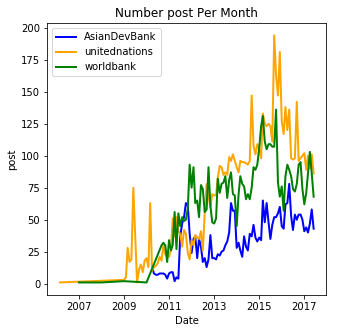

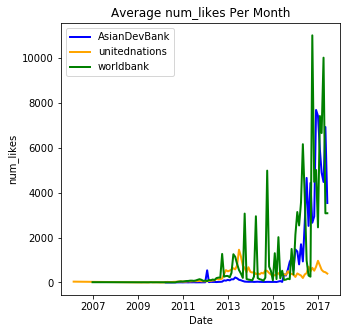

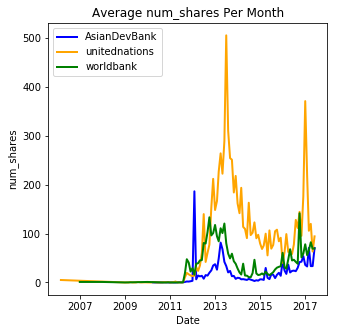

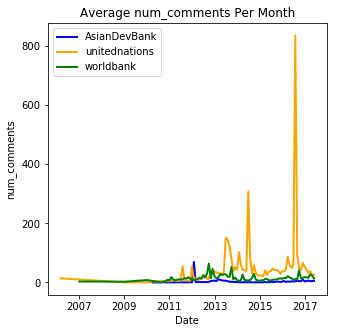

In [405]:
#print(mapdefdata.keys())
graph_data(mapdefdata)

In [31]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

In [300]:
def identify_correlations(data):
    data.corr()
    xcols = ["lnum_likes","photo","video","llen_message","positive_polarity","negative_polarity","message_subjectivity","llast_post_hrs",
         "num_post_L24hrs","num_post_L7days","num_post_L30days",
         "avg_num_likes_L7days","avg_num_likes_L30days","avg_num_shares_L7days","avg_num_shares_L30days","avg_num_comments_L7days","avg_num_comments_L30days"]

    temp = data[xcols]
    corr = temp.corr(method="pearson")

    #Examine variables highly correlated with log error (there is none b/c model is quite fit -- so question is can we find additional?)
    corr_y_high = []
    for col in corr.columns:
        if col != "lnum_likes" and abs(corr["lnum_likes"][col]) >= 0.1:
            corr_y_high.append(col)
    print(corr_y_high)
    
    temp = wbdata[xcols]
    corr = temp.corr(method="pearson")
    multicollinearity = []
    for i, col in enumerate(corr.columns):
        for j in range(i+1,len(corr.columns)):
            if i != j:
                if abs(corr[col][corr.columns[j]]) > 0.5:
                    multicollinearity.append([col,corr.columns[j],corr[col][corr.columns[j]]])
    #show all variables that have a high correlation with y
    print(multicollinearity)

In [439]:
import statsmodels.api as sm
import numpy as np
import math

def analyze_impact(data,num,show):
    
    train = data
    
    #add one to get eliminate problem of being undefined
    min_year = train['publish_year'].min()
    lhsvars = ["num_likes","num_comments","num_shares"]
    for v in lhsvars:
        train["l"+v] = np.log(train[v]+1)
    for v in ["len_message","last_post_hrs","avg_num_likes_L7days","avg_num_likes_L30days"]:
        train["l"+v] = np.log(train[v]+1)
    train['fhour']= (np.floor(train['publish_hour']/2)*2).astype(int)
    #print(train['fhour'].value_counts())
    train = pd.concat([train, pd.get_dummies(train["fhour"], prefix="hr")], axis=1)
    train = pd.concat([train, pd.get_dummies(train['day_of_week'], prefix="dow")], axis=1)
    train = pd.concat([train, pd.get_dummies(train['publish_year'], prefix="yr")], axis=1)
    train = pd.concat([train, pd.get_dummies(train['publish_month'], prefix="mt")], axis=1)   
    
    del train["yr_"+str(min_year)]
    del train["mt_1"]
    del train["dow_0"]
    del train["hr_0"]
    #del train["povertyineqgrowth"]
    
    print(train.shape)
    train["intercept"] = 1.0
    
    subcols = ['aid_effectiveness','climate_change','corruption_governance','data_technology','education','finance_investment',
           'gender','global_health','infrastructure','intltrade','migration','other']
    #Good to create asset values (or intensity of sharing over prior months)
    if num == 1 :
        xcols = ["intercept", "photo","video","llen_message","positive_polarity","negative_polarity","message_subjectivity","llast_post_hrs",
                 "num_post_L30days","other"] + subcols
        #xcols.remove("povertyineqgrowth")
        train[xcols].to_csv('C:\\JobApplications\\Facebook\\regression_data.csv')
        train = train[train["num_post_L30days"].isnull()==False]
        #train = train[train["avg_num_comments_L30days"].isnull()==False]  #something wrong with how this data is constructed
    else:
        xcols = ["intercept", "photo","video","llen_message","positive_polarity","negative_polarity","message_subjectivity","llast_post_hrs"] + list(subject.keys())
        train = train[train["llast_post_hrs"].isnull()==False]
    for c in train.columns:
        if c.startswith("hr_",0) | c.startswith("yr_",0) | c.startswith("mt_",0) | c.startswith("dow_",0):
            xcols.append(c)

    dfresults = pd.DataFrame()
    #print(train.columns)
    for v in lhsvars:
        logit = sm.OLS(train["l"+v].astype('float'),train[xcols].astype('float'))
        result = logit.fit()
        if show == 1:
            print(result.summary())
        dfresults["Est"+v] = result.params
        dfresults['Pval'+v] = result.pvalues
        
    xcols1 = ['intercept','photo','video','llen_message', 'message_subjectivity', 'num_post_L7days', 'num_post_L30days', 'lavg_num_likes_L7days', 'lavg_num_likes_L30days']
    for c in train.columns:
        if c.startswith("hr_",0) | c.startswith("yr_",0) | c.startswith("mt_",0) | c.startswith("dow_",0):
            xcols1.append(c)
    train["intercept"] = 1.0
    for v in lhsvars:
        lr = sm.OLS(train["l"+v].astype('float'),train[xcols].astype('float'))
        result = lr.fit()
        dfresults["Est1"+v] = result.params
        dfresults['Pval1'+v] = result.pvalues
    return(dfresults)

In [440]:
result = {}
#print(mapdefdata['AsianDevBank'].columns)
for w, data in mapdefdata.items():
    #print(w, mapdefdata[w].columns)
    result[w] = analyze_impact(mapdefdata[w],1,0)

(3033, 118)
(5123, 119)
(7084, 119)
(7322, 120)
(4591, 119)
(5534, 119)
(6006, 121)


In [441]:
# Automate the key factors resulting in more positive versus more negative impacts on likes, comments and re-shares
#result.sort_values('Estnum_likes',ascending=False,inplace=True)
#result.reset_index(inplace=True)
# Let us try to rank the change in coefficient estimates in terms of most important to least important factors
# Let us also try to output graphs that synthesize information easily. Note that it is best to standardize values
# Particularly ones that are not a 0-1 variable

def mapcolors(row):
    colors = []
    #print("ENTER")
    for v in row:
        if v <= 0.01:
            colors.append('blue')
        elif v <= 0.05:
            colors.append('mediumslateblue')
        elif v <= 0.1:
            colors.append('slateblue')
        else:
            colors.append('lightgrey')
    return(colors)

def graph_significance(result,pagename):

    lhs = ["num_likes","num_shares","num_comments"]
    result1 = result.round(3)
    result1.reset_index(inplace=True)
    #print(result1.round(3).head())

    for v in ['llen_message','llast_post_hrs','num_post_L30days']:
        #print(type(v))
        for l in lhs:
            result1.loc[result1['index'] == v,["Est"+l]]= result1.loc[result1['index'] == v,["Est"+l]]*wbdata[v].std()

    #Create a mapping of data to enhance printing:
    mapnames = {}
    mname = ['January','February','March','April','May','June','July','August','September','October','November','December']
    downame = ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']
    for i in range(1,13):
        mapnames['mt_'+str(i)] = mname[i-1]
    for i in range(1,25):
        mapnames['hr_'+str(i)] = 'Hour '+str(i)
    for i in range(0,7):
        mapnames['dow_'+str(i)] = downame[i]
    
    xcols = ["photo","video","llen_message","positive_polarity","negative_polarity","message_subjectivity","llast_post_hrs",
             "num_post_L30days"]
    xnames = ["Photo","Video","Message Length (log)","Positive Polarity","Negative Polarity","Subjectivity","Hours Since Last Post (log)",
              "# of Posts (30 days)"]
    for i in range(0,len(xcols)):
        mapnames[xcols[i]] = xnames[i]
    subcols = ['aid_effectiveness','climate_change','corruption_governance','data_technology','education','finance_investment',
           'gender','global_health','infrastructure','intltrade','migration','other']
    subnames = ['Aid Effectiveness','Climate Change','Corruption & Governance','Data & Technology','Education','Finance & Investment',
           'Gender','Global Health','Infrastructure','International Trade','Migration','Other']
    for i in range(0,len(subcols)):
        mapnames[subcols[i]] = subnames[i]

    mapnames['num_likes'] = '# of Likes'
    mapnames['num_shares'] = '# of Shares'
    mapnames['num_comments'] = '# of Comments'
    result1['newnames'] = list(map(mapnames.get,result1['index']))
    result1.sort_values('Estnum_likes',inplace=True)

    #ax = plt.subplot(9, 9, 1)
    fig = plt.figure(figsize=(12, 16))
    fig.suptitle(pagename)
    result1['temp_yr'] = [row.find('yr') for row in result1['index']]
    result1['temp_hr'] = [row.find('hr') for row in result1['index']]
    result1['temp_mt'] = [row.find('mt') for row in result1['index']]
    result1['temp_dow'] = [row.find('dow') for row in result1['index']]
    result1['temp_sub'] = [0 if row in subcols else -1 for row in result1['index']]

    result1 = result1[(result1['temp_yr'] < 0) & (result1['index'] != 'intercept')]
    result1_hr = result1[(result1['temp_hr']==0)]
    result1_mt = result1[(result1['temp_mt']==0)]
    result1_sub = result1[(result1['temp_sub']==0)]
    result1_dow = result1[(result1['temp_dow']==0)]
    result1_other = result1[(result1['temp_hr']<0) & (result1['temp_mt']<0) & (result1['temp_dow']<0) & (result1['temp_sub']<0)]
    #result1_other.sort_values("Est"+l,ascending=False,inplace=True)

    #Plot for hourly data
    for i,l in enumerate(lhs):
        ax = fig.add_subplot(4,3,1+i)
        ax.set_title(mapnames[l])
        colorvals = mapcolors(result1_hr['Pval'+l])
        ax.barh(range(len(result1_hr)), result1_hr['Est'+l], color=colorvals, align="center")
        ax.set_yticks(range(len(result1_hr)))
        if i == 0:
            ax.set_yticklabels(result1_hr['newnames'])
        else:
            ax.tick_params(labelleft='off')
        if i == len(lhs)-1:
            ax.set_ylabel("Relative to Midnight")
            ax.yaxis.set_label_position("right")
        #ax.set_xlabel('Change in '+mapnames[l])
    for i,l in enumerate(lhs):
        #plt.show()
        #Plot for monthly data
        ax = fig.add_subplot(4,3,4+i)
        #ax.set_title(mapnames[l])
        colorvals = mapcolors(result1_dow['Pval'+l])
        ax.barh(range(len(result1_dow)), result1_dow['Est'+l], color=colorvals, align="center")
        ax.set_yticks(range(len(result1_dow)))
        if i == 0:
            ax.set_yticklabels(result1_dow['newnames'])
        else:
            ax.tick_params(labelleft='off')
        if i == len(lhs)-1:
            ax.set_ylabel("Relative to Sunday")
            ax.yaxis.set_label_position("right")
        #ax.set_xlabel('Change in '+mapnames[l])
    for i,l in enumerate(lhs):
        #Plot for other data
        ax = fig.add_subplot(4,3,7+i)
        #ax.set_title(mapnames[l])
        colorvals = mapcolors(result1_other['Pval'+l])
        ax.barh(range(len(result1_other)), result1_other['Est'+l], color=colorvals, align="center")
        ax.set_yticks(range(len(result1_other)))
        if i == 0:
            ax.set_yticklabels(result1_other['newnames'])
        else:
            ax.tick_params(labelleft='off')
        if i == len(lhs)-1:
            ax.set_ylabel("Relative to Various")
            ax.yaxis.set_label_position("right")
        #ax.set_xlabel('Change in '+mapnames[l])
    for i,l in enumerate(lhs):
        #Plot for other data
        ax = fig.add_subplot(4,3,10+i)
        #ax.set_title(mapnames[l])
        colorvals = mapcolors(result1_sub['Pval'+l])
        ax.barh(range(len(result1_sub)), result1_sub['Est'+l], color=colorvals, align="center")
        ax.set_yticks(range(len(result1_sub)))
        if i == 0:
            ax.set_yticklabels(result1_sub['newnames'])
        else:
            ax.tick_params(labelleft='off')
        if i == len(lhs)-1:
            ax.set_ylabel("Relative to Poverty & Inequality")
            ax.yaxis.set_label_position("right")
        ax.set_xlabel('Change in '+mapnames[l])

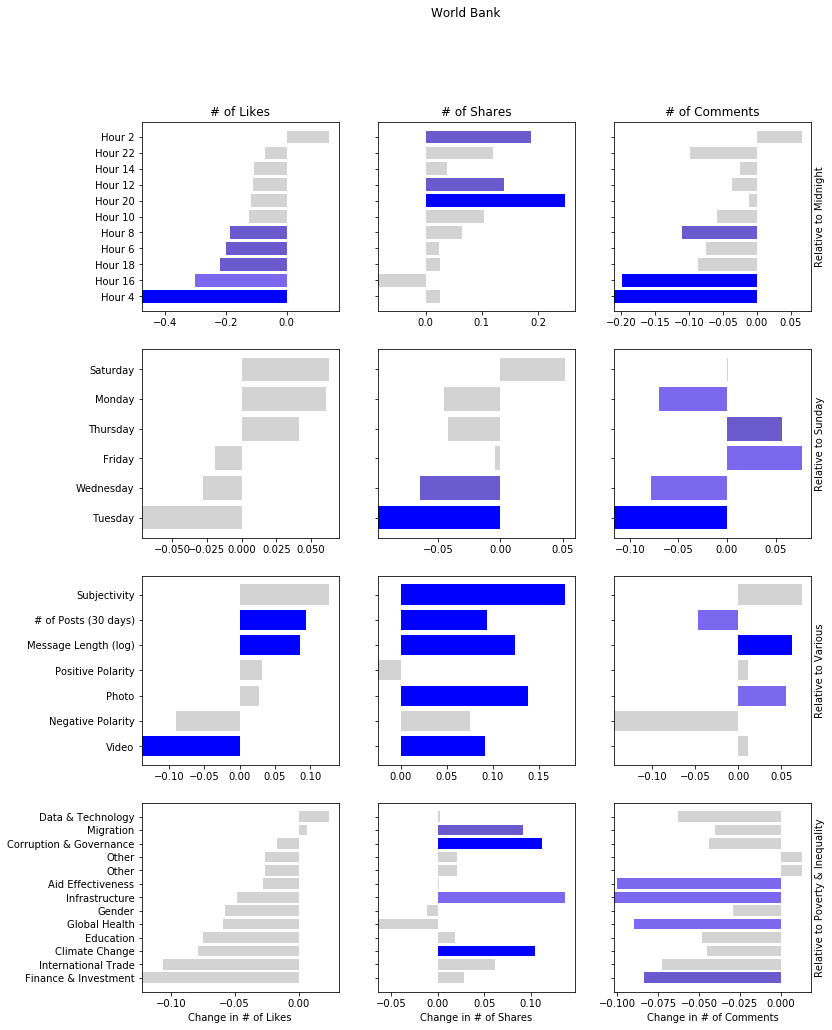

In [442]:
graph_significance(result['worldbank'],'World Bank')

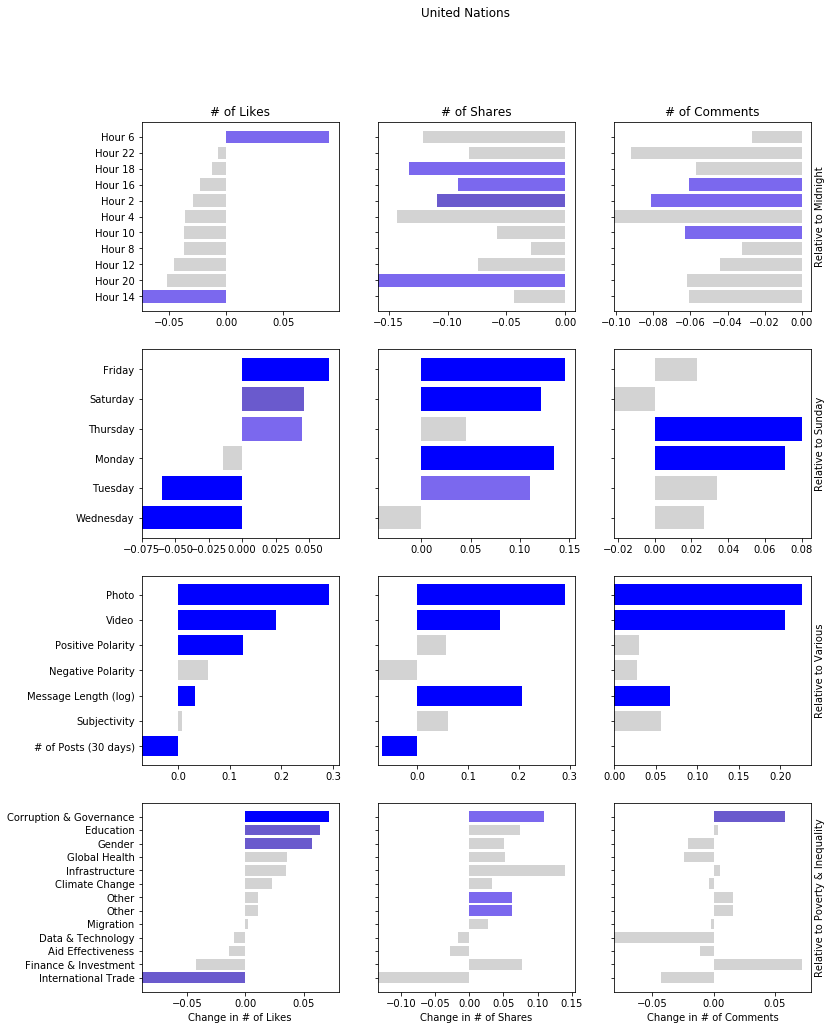

In [443]:
graph_significance(result['unitednations'],'United Nations')

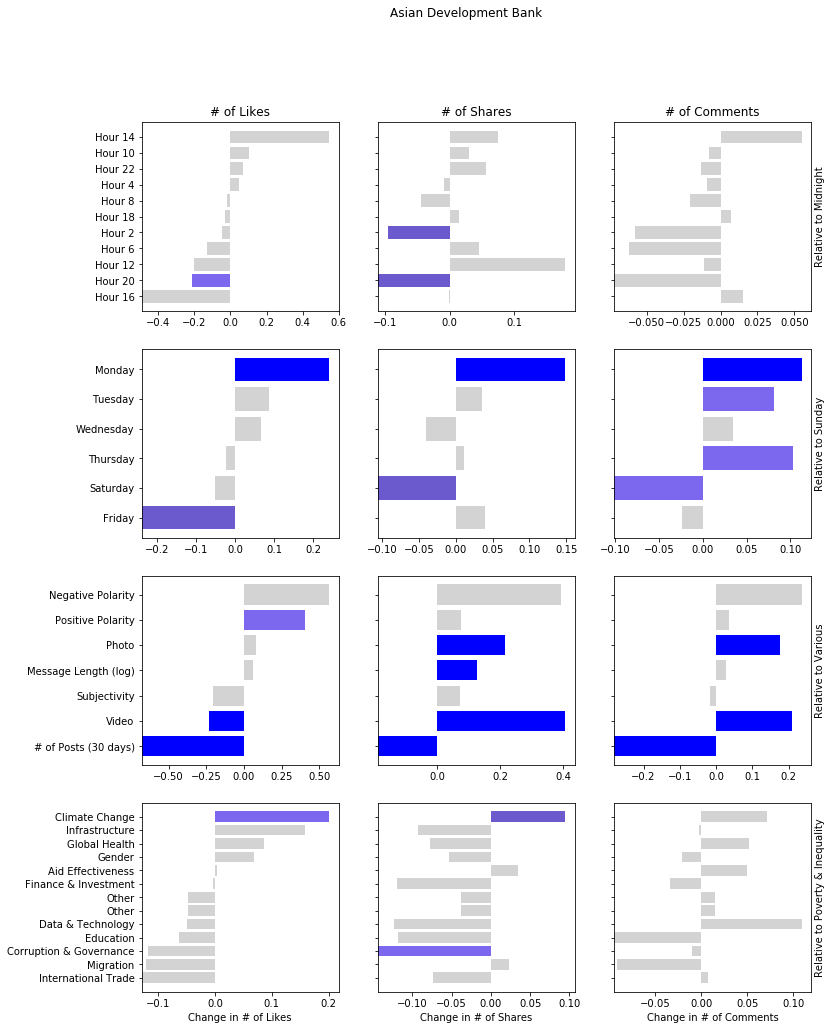

In [444]:
graph_significance(result['AsianDevBank'],'Asian Development Bank')

## Factors influencing engagement on Facebook

Regression estimation allows us to focus on different factors that influence engagement on Facebook.  As a first pass simple OLS is run (ignoring serial correlation in errors that and will likely reduce significance of the estimates further).  While these factors are not causal they do provide a way to narrow down the set of strategies that could matter in increasing user engagement.

Broad findings:
1. Posts with photos typically are more effective in obtaining likes, comments, and shares compared to posts that do not.  They also are generally more effective than video potentially due to the hurdle (even if it is small one) of needing to watch the video.
2. Posting time does tend to matter in generating more likes, comments, and shares.  Posts that occur on Sunday/Monday generally tend to do better than those that occur on Friday or Saturday.
3. Posts with longer messages on average do increase likes and comments.  Whether this is related to quality of content or other factors is still unknown.
4. There are indications that the core followers of the organizations differ substantially in terms of their response rates to different content.  For the World Bank there is no difference in likes among the different topic postings, but topics of migration, corruption and governance, and infrastructure getting more shares.  The UN gets more likes on topics of corruption and governance, gender, and education.  ADB only receives positive responses to topics of climate change.

# Conclusions